# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [2]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,642487,34.4,1321322,70.6,1321322,70.6
Vcells,1147059,8.8,8388608,64.0,1632080,12.5


Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [3]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

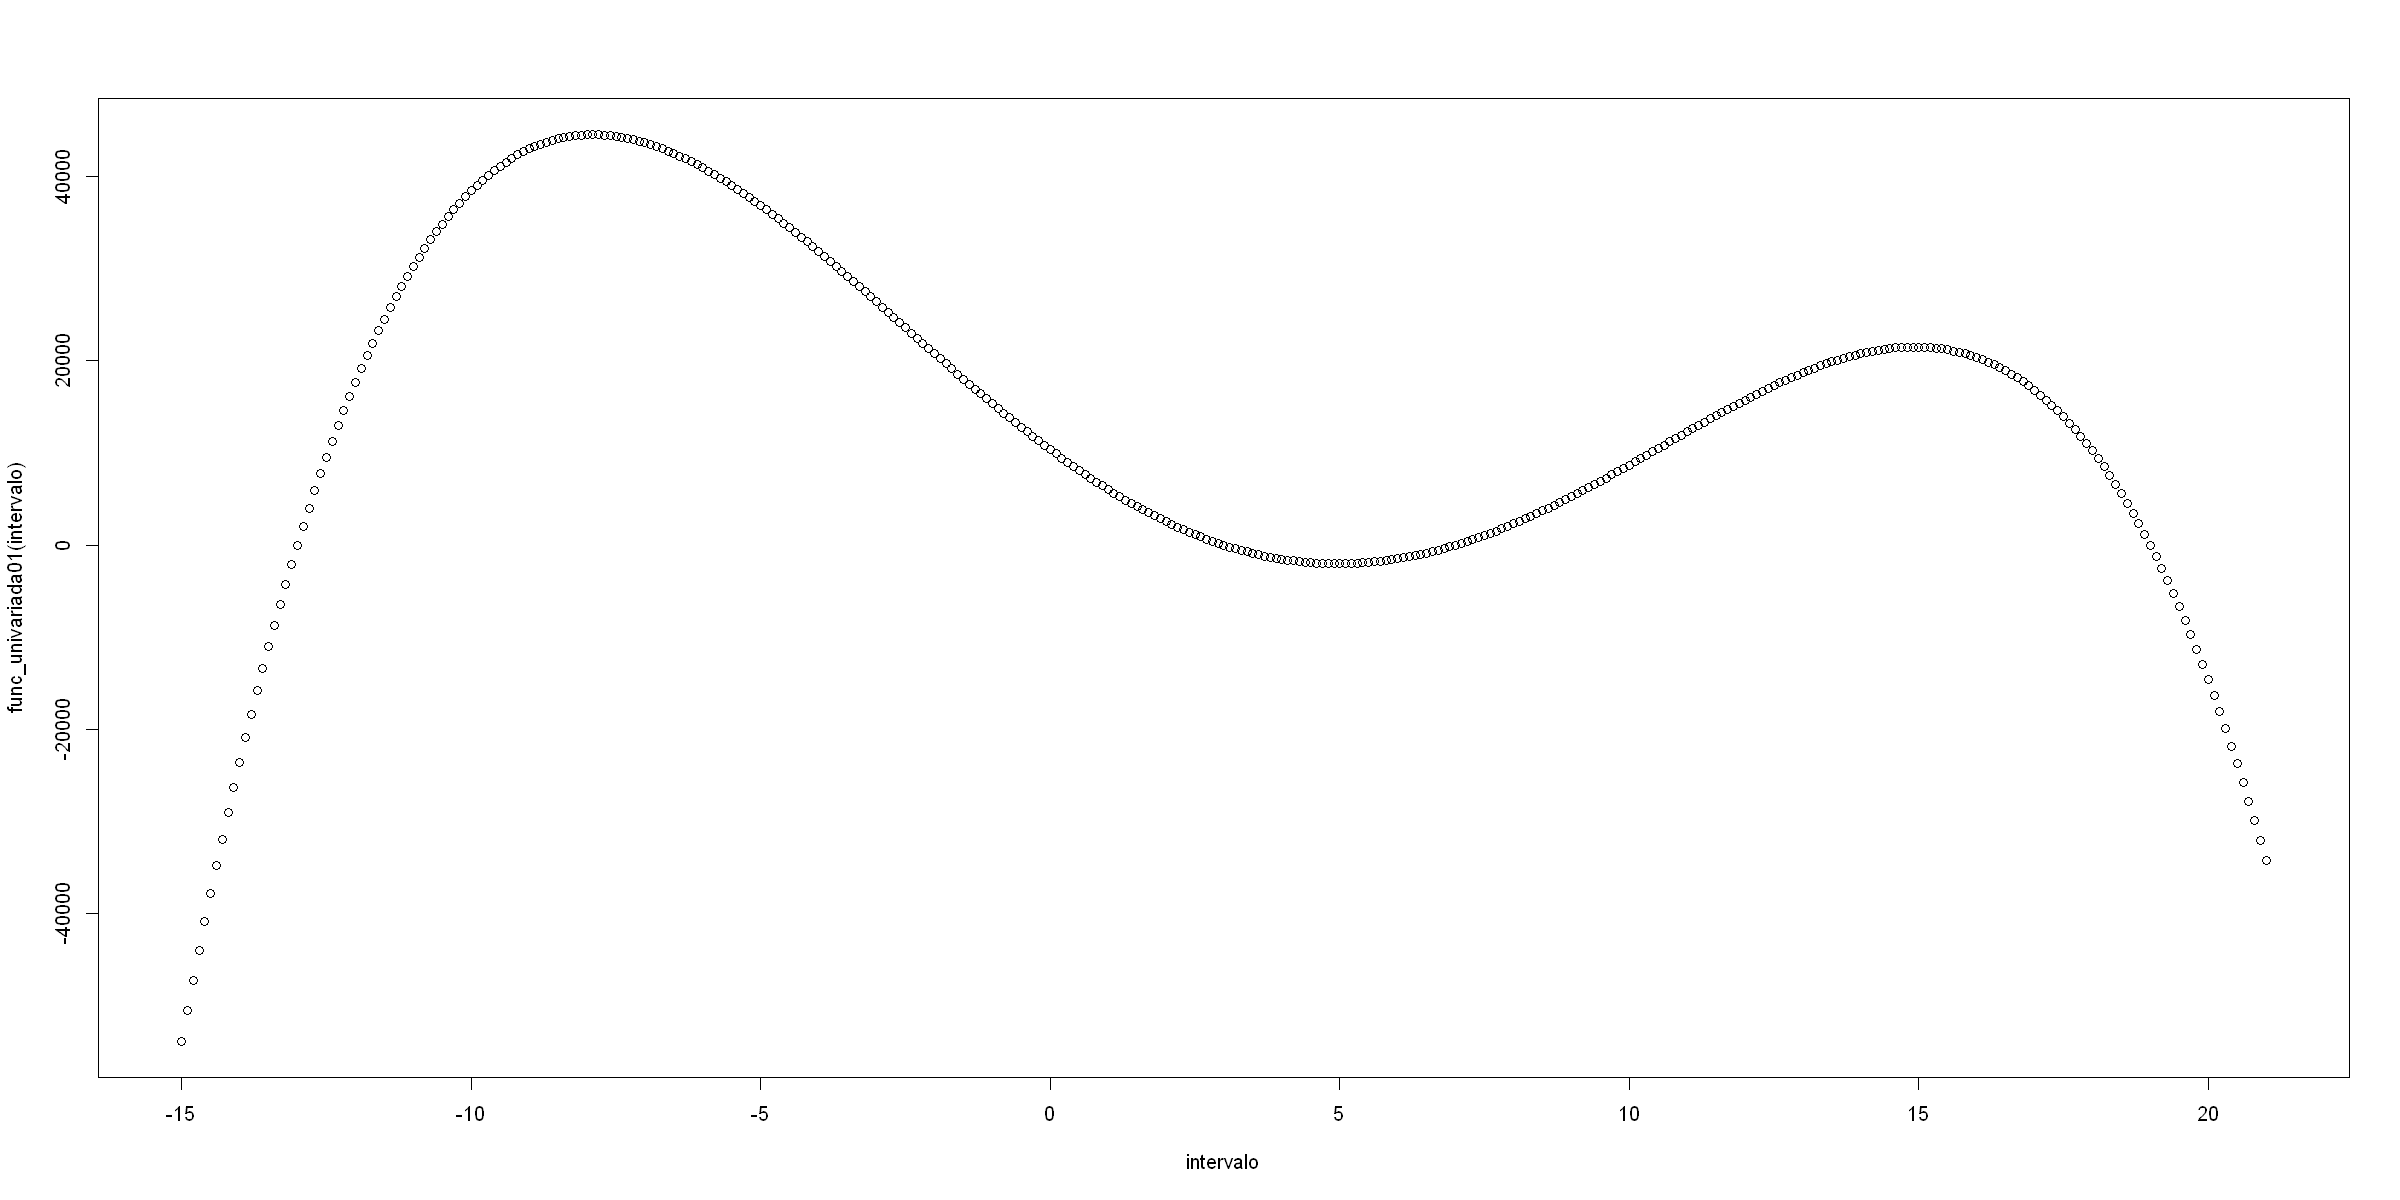

In [4]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [5]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [6]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [7]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [8]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=88.1 : y = -9.65e+07 : 0.0 secs : initdesign

[mbo] 0: x=-48.1 : y = -1.33e+07 : 0.0 secs : initdesign

[mbo] 0: x=10.7 : y = 1.13e+04 : 0.0 secs : initdesign

[mbo] 0: x=-68.4 : y = -5.23e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -75.4649 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       75.465  |proj g|=    0.0062922
At iterate     1  f =       75.465  |proj g|=     0.0062909
At iterate     2  f =       75.445  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 75.4451

F = 75.4451
final  value 75.445133 
converged


[mbo] 1: x=-45.6 : y = -1.07e+07 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -91.62121 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       91.621  |proj g|=    0.0025368
At iterate     1  f =       91.621  |proj g|=     0.0025353
At iterate     2  f =       91.616  |proj g|=     0.0003744
At iterate     3  f =       91.616  |proj g|=    4.4833e-05
At iterate     4  f =       91.616  |proj g|=    6.7478e-07
At iterate     5  f =       91.616  |proj g|=    1.2431e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.24311e-09
final functio

[mbo] 2: x=-11.1 : y = 2.9e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -109.1415 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       109.14  |proj g|=     0.002754
At iterate     1  f =       109.14  |proj g|=      0.002753
At iterate     2  f =       109.13  |proj g|=    0.00073105
At iterate     3  f =       109.13  |proj g|=    0.00013661
At iterate     4  f =       109.13  |proj g|=    5.4365e-06
At iterate     5  f =       109.13  |proj g|=    4.2671e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.26711e-08
final functio

[mbo] 3: x=0.891 : y = 6.48e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -125.3806 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       125.38  |proj g|=    0.0025063
At iterate     1  f =       125.38  |proj g|=     0.0025059
At iterate     2  f =       125.37  |proj g|=     0.0010881
At iterate     3  f =       125.37  |proj g|=    0.00027155
At iterate     4  f =       125.37  |proj g|=    2.2538e-05
At iterate     5  f =       125.37  |proj g|=    5.2202e-07
At iterate     6  f =       125.37  |proj g|=    9.7466e-10

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 4: x=-23.8 : y = -7.66e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -141.5905 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       141.59  |proj g|=    0.0011334
At iterate     1  f =       141.59  |proj g|=     0.0011332
At iterate     2  f =       141.59  |proj g|=    0.00010799
At iterate     3  f =       141.59  |proj g|=    1.1558e-05
At iterate     4  f =       141.59  |proj g|=    1.3568e-07
At iterate     5  f =       141.59  |proj g|=    1.7301e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.73013e-10
final functio

[mbo] 5: x=6.4 : y = -994 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -156.255 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       156.25  |proj g|=   0.00028219
At iterate     1  f =       156.25  |proj g|=    0.00028216

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000282165
final function value 156.255

F = 156.255
final  value 156.254994 
converged


[mbo] 6: x=-5.39 : y = 3.86e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -170.8453 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       170.85  |proj g|=   0.00026459
At iterate     1  f =       170.85  |proj g|=    0.00026457

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000264572
final function value 170.845

F = 170.845
final  value 170.845301 
converged


[mbo] 7: x=-16.7 : y = -1.25e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -185.4087 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       185.41  |proj g|=   0.00040214
At iterate     1  f =       185.41  |proj g|=    0.00040213

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000402126
final function value 185.409

F = 185.409
final  value 185.408650 
converged


[mbo] 8: x=20.7 : y = -2.71e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -201.8673 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       201.87  |proj g|=    0.0006474
At iterate     1  f =       201.87  |proj g|=    0.00064738

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000647376
final function value 201.867

F = 201.867
final  value 201.867285 
converged


[mbo] 9: x=16.5 : y = 1.88e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -216.1668 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       216.17  |proj g|=   0.00051266
At iterate     1  f =       216.17  |proj g|=    0.00051264

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000512641
final function value 216.167

F = 216.167
final  value 216.166760 
converged


[mbo] 10: x=-2.37 : y = 2.28e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -229.5537 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       229.55  |proj g|=   8.3091e-05
At iterate     1  f =       229.55  |proj g|=    8.3089e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.30885e-05
final function value 229.554

F = 229.554
final  value 229.553683 
converged


[mbo] 11: x=-8.32 : y = 4.44e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -242.7149 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       242.71  |proj g|=   3.6406e-06
At iterate     1  f =       242.71  |proj g|=    3.6405e-06

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.64054e-06
final function value 242.715

F = 242.715
final  value 242.714864 
converged


[mbo] 12: x=18.7 : y = 3.46e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -255.6266 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       255.63  |proj g|=   0.00072858
At iterate     1  f =       255.63  |proj g|=    0.00072856

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000728557
final function value 255.627

F = 255.627
final  value 255.626565 
converged


[mbo] 13: x=13.6 : y = 2.01e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -268.6755 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       268.68  |proj g|=   0.00088467
At iterate     1  f =       268.68  |proj g|=    0.00088465
At iterate     2  f =       268.67  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 268.671

F = 268.671
final  value 268.670925 
converged


[mbo] 14: x=3.65 : y = -1.11e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -281.6682 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       281.67  |proj g|=    0.0016384
At iterate     1  f =       281.67  |proj g|=     0.0016383
At iterate     2  f =       281.65  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 281.652

F = 281.652
final  value 281.651580 
converged


[mbo] 15: x=-13.6 : y = -1.3e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -294.7073 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       294.71  |proj g|=    0.0029722
At iterate     1  f =       294.71  |proj g|=      0.002972
At iterate     2  f =       294.64  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 294.637

F = 294.637
final  value 294.636975 
converged


[mbo] 16: x=26.5 : y = -2.74e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -310.2067 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       310.21  |proj g|=    0.0034611
At iterate     1  f =       310.21  |proj g|=     0.0034609
At iterate     2  f =       310.13  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 310.126

F = 310.126
final  value 310.125732 
converged


[mbo] 17: x=23.6 : y = -1.15e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -323.4019 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        323.4  |proj g|=     0.003609
At iterate     1  f =        323.4  |proj g|=     0.0036089
At iterate     2  f =       323.34  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 323.343

F = 323.343
final  value 323.342795 
converged


[mbo] 18: x=8.62 : y = 4.1e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -336.1079 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       336.11  |proj g|=    0.0060137
At iterate     1  f =       336.11  |proj g|=     0.0060133
At iterate     2  f =       335.89  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 335.889

F = 335.889
final  value 335.889492 
converged


[mbo] 19: x=-6.89 : y = 4.35e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -348.018 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       348.02  |proj g|=    0.0053141
At iterate     1  f =       348.02  |proj g|=     0.0053138
At iterate     2  f =        347.9  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 347.897

F = 347.897
final  value 347.896587 
converged


[mbo] 20: x=-9.66 : y = 4.04e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -360.0459 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.05  |proj g|=    0.0077035
At iterate     1  f =       360.05  |proj g|=     0.0077029
At iterate     2  f =       359.75  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 359.751

F = 359.751
final  value 359.750957 
converged


[mbo] 21: x=-3.92 : y = 3.14e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -371.7815 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       371.78  |proj g|=    0.0057432
At iterate     1  f =       371.78  |proj g|=     0.0057429
At iterate     2  f =       371.71  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 371.713

F = 371.713
final  value 371.713035 
converged


[mbo] 22: x=15 : y = 2.15e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -383.7189 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.72  |proj g|=    0.0063851
At iterate     1  f =       383.72  |proj g|=     0.0063847
At iterate     2  f =       383.64  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 383.639

F = 383.639
final  value 383.638769 
converged


[mbo] 23: x=-0.775 : y = 1.42e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -395.672 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       395.67  |proj g|=    0.0063424
At iterate     1  f =       395.67  |proj g|=      0.006342
At iterate     2  f =       395.65  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 395.651

F = 395.651
final  value 395.650743 
converged


[mbo] 24: x=12.2 : y = 1.63e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -407.46 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       407.46  |proj g|=    0.0067673
At iterate     1  f =       407.46  |proj g|=     0.0067669
At iterate     2  f =       407.45  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 407.452

F = 407.452
final  value 407.451651 
converged


[mbo] 25: x=-7.61 : y = 4.45e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  313.1122 
  - best initial criterion value(s) :  -418.2878 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       418.29  |proj g|=    0.0074251
At iterate     1  f =       418.29  |proj g|=     0.0074246
At iterate     2  f =       418.27  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 418.268

F = 418.268
final  value 418.267528 
converged


In [9]:
tb_resultados  <- as.data.table( run$opt.path )

In [10]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
88.1124160,-9.648745e+07,0,NA,NA,0.01,NA,NA,NA,initdesign,NA,NA,NA
-48.1492408,-1.331575e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
10.7239795,1.129503e+04,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-68.4436930,-5.226338e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-45.5673127,-1.073704e+07,1,NA,NA,0.00,-2693969.217,NA,0.14,infill_ei,0.34,37593612.09,-40513820.838
-11.1154113,2.902533e+04,2,NA,NA,0.00,-8945017.653,NA,0.03,infill_ei,0.29,17461025.27,3665472.375
0.8912098,6.481091e+03,3,NA,NA,0.00,-2842895.116,NA,0.03,infill_ei,0.28,4714424.88,1715189.187
-23.8200311,-7.659454e+05,4,NA,NA,0.00,-1620125.003,NA,0.01,infill_ei,0.34,4917116.41,-696665.601
6.4023861,-9.939802e+02,5,NA,NA,0.00,-540434.068,NA,0.03,infill_ei,0.31,947304.05,318933.015


In [11]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.609794,44465.99,25,NA,NA,0,-8054.981,NA,0.03,infill_ei,0.36,20045.55,44466.32


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?